In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle

In [ ]:
from PIL import Image

In [ ]:
image_names = os.listdir('../data/loc_data')[1:]

In [53]:
loc_data_xy={}
for name in image_names:
    locpath = '../data/loc_data/' + name
    f = open(locpath,'rb')
    loc_dict = pickle.load(f)
    loc_data_xy[name] = np.array(loc_dict['barycenters'])

In [54]:
len(loc_data_xy)

1000

In [55]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    #plt.pause(0.001)  # pause a bit so that plots are updated

../ALLSTIMULI/i05june05_static_street_boston_p1010764.jpeg
../ALLSTIMULI/i05june05_static_street_boston_p1010785.jpeg
../ALLSTIMULI/i05june05_static_street_boston_p1010800.jpeg
../ALLSTIMULI/i05june05_static_street_boston_p1010806.jpeg
../ALLSTIMULI/i05june05_static_street_boston_p1010808.jpeg
../ALLSTIMULI/i05june05_static_street_boston_p1010816.jpeg
../ALLSTIMULI/i05june05_static_street_boston_p1010855.jpeg
../ALLSTIMULI/i05june05_static_street_boston_p1010885.jpeg
../ALLSTIMULI/i05june05_static_street_boston_p1010907.jpeg
../ALLSTIMULI/i10feb04_static_cars_highland_img_0843.jpeg
../ALLSTIMULI/i10feb04_static_cars_highland_img_0847.jpeg
../ALLSTIMULI/i10feb04_static_techsquare_img_0873.jpeg
../ALLSTIMULI/i30may05_static_street_cambridge_p1010717.jpeg
../ALLSTIMULI/i30may05_static_street_cambridge_p1010735.jpeg
../ALLSTIMULI/i1032358.jpeg
../ALLSTIMULI/i1032393.jpeg
../ALLSTIMULI/i1082647.jpeg
../ALLSTIMULI/i1508828.jpeg
../ALLSTIMULI/i2057541.jpeg
../ALLSTIMULI/i4466881.jpeg
../ALLST

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


../ALLSTIMULI/i12049788.jpeg
../ALLSTIMULI/i13910717.jpeg
../ALLSTIMULI/i14020903.jpeg
../ALLSTIMULI/i19023164.jpeg
../ALLSTIMULI/i20708508.jpeg
../ALLSTIMULI/i24622350.jpeg
../ALLSTIMULI/i33894157.jpeg


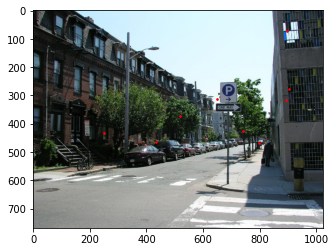

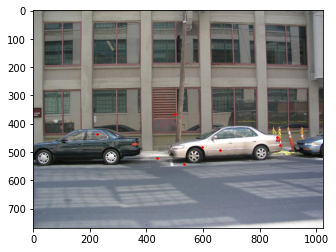

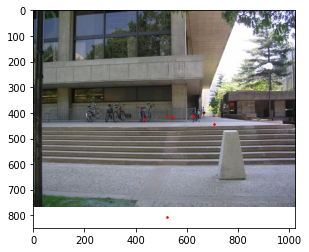

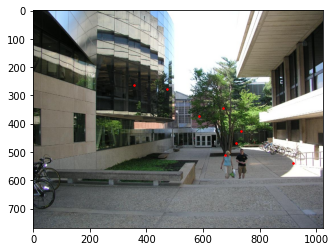

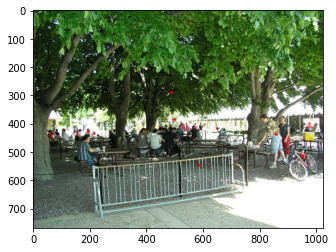

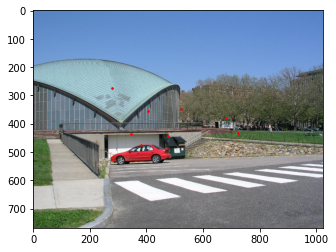

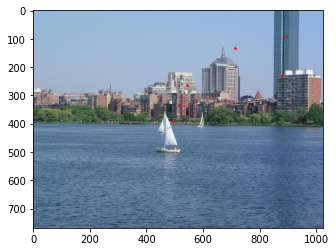

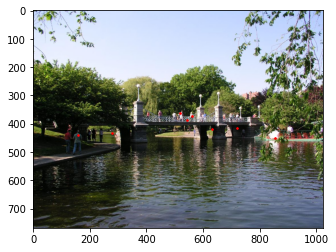

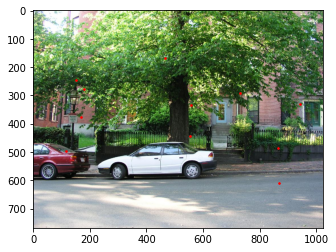

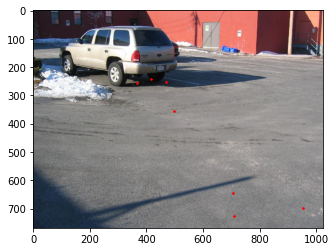

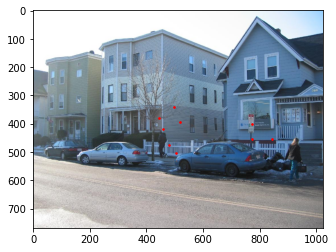

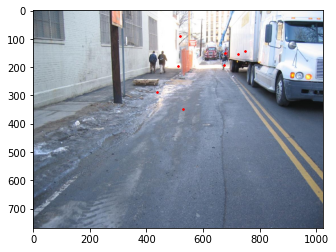

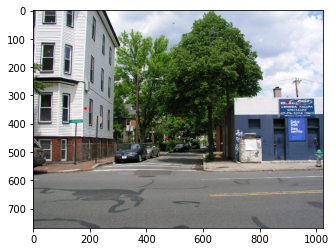

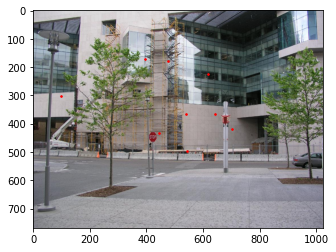

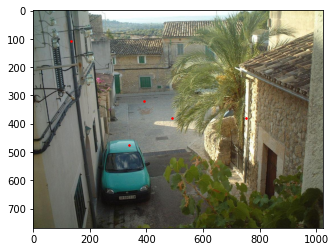

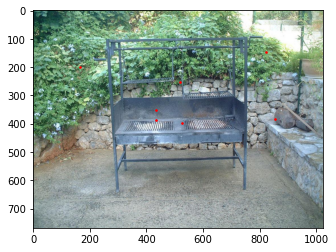

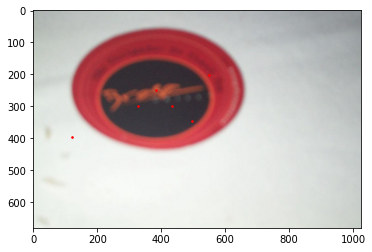

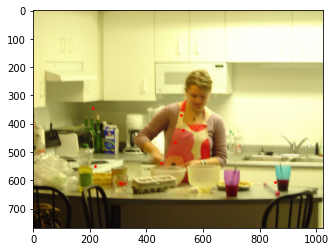

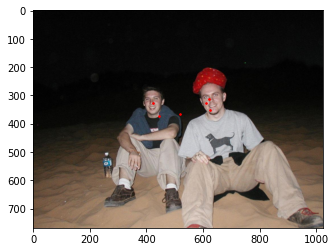

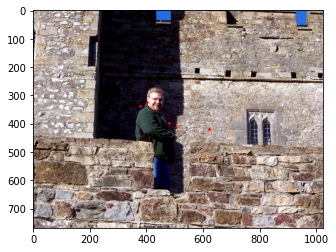

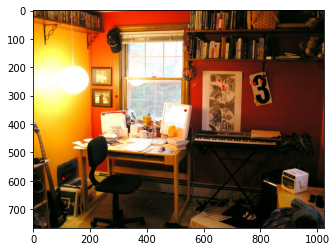

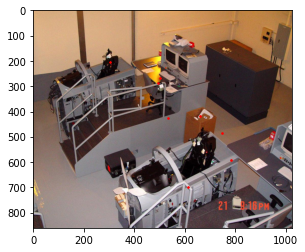

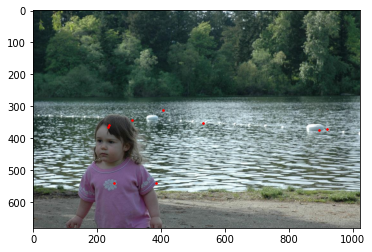

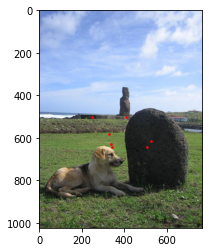

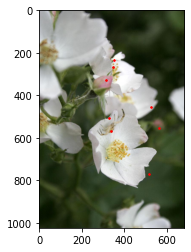

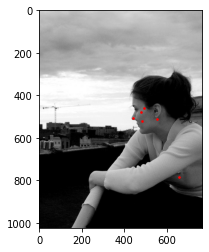

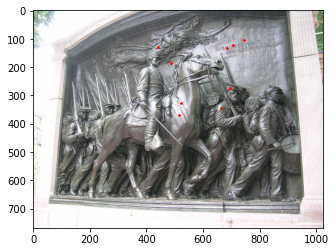

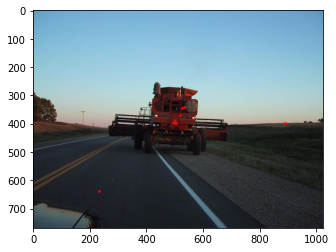

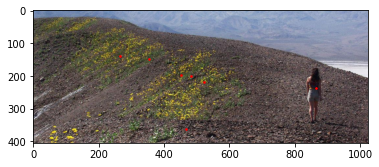

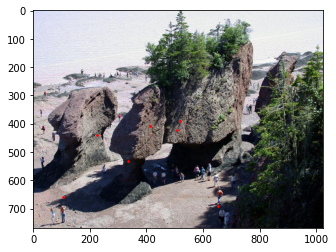

In [56]:
for name in image_names[:30]:
    plt.figure()
    impath = '../data/ALLSTIMULI/' + name + '.jpeg'
    print(impath)
    img = Image.open(impath)
    img_npy = np.asarray(img)
    landmarks = np.array(loc_data_xy[name])
    show_landmarks(img_npy, landmarks)
    #loc_ij = []
    #for coord in loc_xy:
    #    loc_ij += [[coord[1], coord[0]]]
    #loc_ij = np.array(loc_ij)
    #plt.plot(loc_data_ij_part[:,1], loc_data_ij_part[:,0])
    #for i, coord in enumerate(loc_xy):
    #    plt.plot(coord[0], coord[1], 'r+', ms=32)
    

# Dataset class

In [57]:
class SaccadeLandmarksDataset(Dataset):
    """Saccade Landmarks dataset."""

    def __init__(self, loc_dict, img_dir, transform=None):
        """
        Args:
            loc_dir (string): Path to the saccade location file
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.loc_dict = loc_dict
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.loc_dict)

    def __getitem__(self, idx):

        img_name = os.listdir(self.img_dir)[idx+2]
        img_path = os.path.join(self.img_dir,img_name)
        image = io.imread(img_path)
        name = img_name[:-5]
        landmarks = self.loc_dict[name]
        landmarks = np.array([landmarks])
        landmarks = landmarks.reshape(-1, 2) #.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (768, 1024, 3) (9, 2)
1 (768, 1024, 3) (8, 2)
2 (768, 1024, 3) (6, 2)
3 (768, 1024, 3) (8, 2)


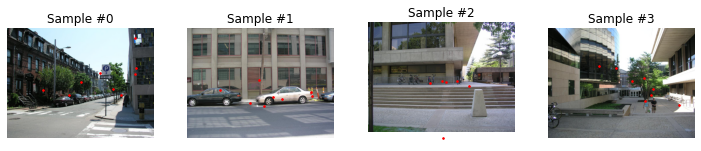

In [58]:
saccade_dataset = SaccadeLandmarksDataset(loc_dict=loc_data_xy,
                                    img_dir='../data/ALLSTIMULI/')

fig = plt.figure(figsize=(10,5))

for i in range(len(saccade_dataset)):
    sample = saccade_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [59]:
len(sample['landmarks'])

8

# Transforms

In [60]:
class RandomSaccadeTo(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        nb_sac = len(landmarks)
        sac_num =  np.random.randint(nb_sac)
        sac = landmarks[sac_num]
        N_X, N_Y = image.shape[:2]
        #img_color_sac = saccade_to(image, (N_X//2, N_Y//2), (sac[1], sac[0]))
        image_roll = np.copy(image)
        image_roll=np.roll(image_roll, N_X//2 - sac[1], axis=0)
        image_roll=np.roll(image_roll, N_Y//2 - sac[0], axis=1)
        return {'image':image_roll, 'pos':sac}

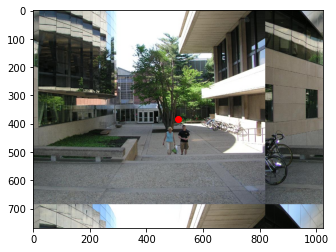

In [61]:
sample_sac = RandomSaccadeTo()(sample)
plt.imshow(sample_sac['image'])
N_X, N_Y = sample_sac['image'].shape[:2]
plt.scatter(N_Y//2, N_X//2, c='r')

In [62]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image_tens = sample['image'].transpose((2, 0, 1))
        return {'image': torch.FloatTensor(image_tens), 'pos': sample['pos']}

In [63]:
sample_tens = ToTensor()(sample_sac)

### Adapted cropped pyramid (squeezed tensor)

In [64]:
from PYramid import cropped_pyramid

In [65]:
class CroppedPyramid(object):
    def __init__(self, width, base_levels, color=True, do_mask=False, verbose=False):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
    
    def __call__(self, sample):
        img_crop, level_size = cropped_pyramid(sample['image'].unsqueeze(0), 
                                               width=self.width, 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True)
        return{'img_crop':img_crop, 'level_size':level_size, 'pos':sample['pos']}
        
    

In [66]:
width=32
base_levels=2
cropped_pyr_transform = CroppedPyramid(width, base_levels)
transformed_data = cropped_pyr_transform(sample_tens)

In [67]:
transformed_data['img_crop'].shape

torch.Size([6, 3, 32, 32])

# Compose transforms

In [68]:
composed_transform = transforms.Compose([RandomSaccadeTo(),
                               ToTensor(),
                               CroppedPyramid(width, base_levels)])

In [69]:
transformed_data = composed_transform(sample)

# Iterating through the dataset

In [70]:
saccade_dataset = SaccadeLandmarksDataset(loc_dict=loc_data_xy,
                                          img_dir='../data/ALLSTIMULI/',
                                          transform=composed_transform)

In [71]:
for i in range(len(saccade_dataset)):
    sample = saccade_dataset[i]

    print(i, sample['img_crop'].size(), sample['level_size'])

    if i == 3:
        break

0 torch.Size([6, 3, 32, 32]) [[768, 1024], [384, 512], [192, 256], [96, 128], [48, 64], [24, 32]]
1 torch.Size([6, 3, 32, 32]) [[768, 1024], [384, 512], [192, 256], [96, 128], [48, 64], [24, 32]]
2 torch.Size([6, 3, 32, 32]) [[768, 1024], [384, 512], [192, 256], [96, 128], [48, 64], [24, 32]]
3 torch.Size([6, 3, 32, 32]) [[768, 1024], [384, 512], [192, 256], [96, 128], [48, 64], [24, 32]]


In [72]:
sample['pos']

array([474, 278])

In [88]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    for level in range(5,0,-1):
        plt.figure()
        images_batch = sample_batched['img_crop'][:,level,:,:,:]
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2

        grid = utils.make_grid(images_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)).clip(0,255).astype('uint8'))

        plt.title('Batch from dataloader, level=' + str(level))


0 torch.Size([4, 6, 3, 32, 32])
1 torch.Size([4, 6, 3, 32, 32])
2 torch.Size([4, 6, 3, 32, 32])
3 torch.Size([4, 6, 3, 32, 32])


<Figure size 432x288 with 0 Axes>

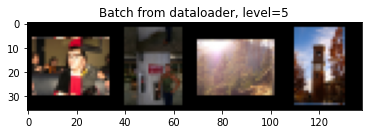

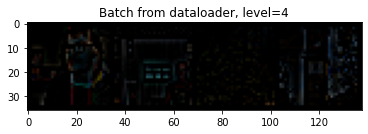

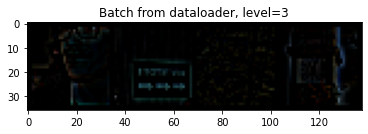

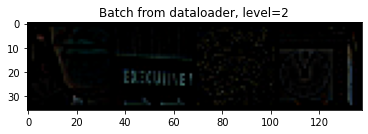

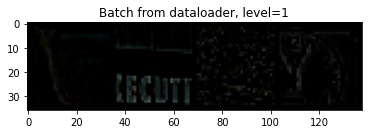

In [89]:
dataloader = DataLoader(saccade_dataset, batch_size=4,
                        shuffle=True, num_workers=0)
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['img_crop'].size())
    if i_batch ==3 :
        plt.figure()
        show_landmarks_batch(sample_batched)    
        break